In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from utils.data_utils import *

In [2]:
# 更改 utils/data_utils.py 中的自訂 function 可重新 reload
from importlib import reload
from utils import data_utils
reload(data_utils)
from utils.data_utils import *

# Read data

In [2]:
load = pd.read_pickle("load.pickle")  
print(f'原始資料數量: {load.shape}')

原始資料數量: (1566192, 3)


# Clean data

## unusal values

### Explore

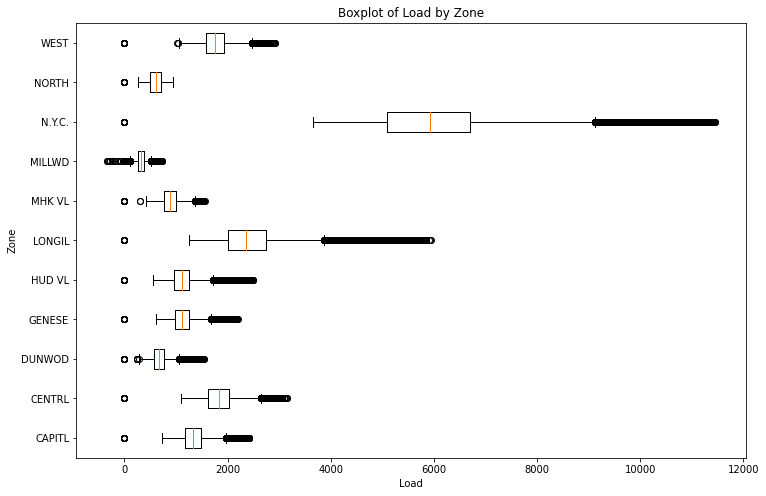

In [3]:
df = load

load_data_by_zone = []
# 遍歷每個類別，將相應的Load數據添加到列表中
for zone, data in df.groupby('Zone')['Load']:
    load_data_by_zone.append(data)

# 繪製箱形圖
plt.figure(figsize=(12, 8))
plt.boxplot(load_data_by_zone, labels=df['Zone'].unique(), vert=False)
plt.xlabel('Load')
plt.ylabel('Zone')
plt.title('Boxplot of Load by Zone')
plt.show()

### Remove 0 and negative

In [4]:
print(f'刪除前資料數量: {df.shape}')
non_pos = df[df['Load']<=0]
print(f'小於等於0的數量: {non_pos.shape}')
load_drop = df.drop(non_pos.index) 
print(f'刪除後資料數量: {load_drop.shape}')

刪除前資料數量: (1566192, 3)
小於等於0的數量: (373, 3)
刪除後資料數量: (1565819, 3)


## duplicate


### Explore

In [5]:
df = load_drop

# 確認有多少重複值
duplicates = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'重複筆數：{duplicates.shape}')

print(duplicates.head(1))
df[(df['Date'] == '2014-11-02 01:00:00')&(df['Zone']=='DUNWOD')]

重複筆數：(3388, 3)
                      Date   Load    Zone
769472 2014-11-02 01:00:00  508.5  DUNWOD


,Date,Load,Zone
769461,2014-11-02 01:00:00,530.3,DUNWOD
769472,2014-11-02 01:00:00,508.5,DUNWOD


### Take an average of duplicates

In [6]:
df= load_drop


# 重複中有兩筆資料的取平均
print(f'刪除前資料數量: {df.shape}')
duplicates_2 = df[df.duplicated(subset=['Date', 'Zone'])]
print(f'type2 重複筆數: {duplicates_2.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'刪除後資料數量: {df_drop.shape}')

load_drop = df_drop

刪除前資料數量: (1565819, 3)
type2 重複筆數: (3388, 3)
刪除後資料數量: (1562431, 3)


## NA 

In [7]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 - 所有時間點 x 11 zones:{hours_df.shape[0]*11}')

df_all_time = df_all_time

目前資料數量: (1562431, 3)
補上所有時間後資料數量: (1699896, 3)
驗算 - 所有時間點 x 11 zones:1699896


### Explore: 以 NYC 為例

In [8]:
df = df_all_time

# 找尋 one zone 的 NA
zone = 'N.Y.C.'
df_onezone = df.loc[df['Zone'] == zone,]
print(f"NYC 資料數量: {df_onezone.shape}")
print(f"NYC NA number: {df_onezone['Load'].isna().sum()}") 

df_onezone = df_onezone

NYC 資料數量: (154536, 3)
NYC NA number: 12494


#### visualize NA on heatmap

In [9]:
# df = df_onezone

# # 呈現 NA heatmap
# vis_na(df, 16, 80) # (END) ALL 至 2023-09-23 23:00:00 (154536)
# vis_na(df[0:2592], 16, 8)

### find and remove large NA periods (All zones 也要用)

In [10]:
df = df_onezone

# 計算年 NA
year_na_count = count_year_na(df)
year_na_count.to_frame()

,Load
Date,
2006-12-31,2533
2007-12-31,12
2008-12-31,80
2009-12-31,155
2010-12-31,34
2011-12-31,19
2012-12-31,2146
2013-12-31,1674
2014-12-31,14


In [11]:
# 根據 year_na_count 遺失值 > 100 的年份逐一視覺畫查閱大量遺失 period
# vis_na_specify(result, '2009-01-01 00:00:00', '2009-12-31 23:00:00', 16, 80)  # 2009 (這一年有缺連續2-4天的，不刪，可用來評估補值結果)
# vis_na_specify(result, '2006-02-06 00:00:00', '2006-12-31 23:00:00', 16, 80) 
# vis_na_specify(result, '2009-01-01 00:00:00', '2009-12-31 23:00:00', 16, 80)
# vis_na_specify(result, '2012-01-01 00:00:00', '2012-12-31 23:00:00', 16, 80)
# vis_na_specify(result, '2013-01-01 00:00:00', '2013-12-31 23:00:00', 16, 80)
# vis_na_specify(result, '2020-01-01 00:00:00', '2020-12-31 23:00:00', 16, 80) 
# vis_na_specify(result, '2023-01-01 00:00:00', '2023-09-23 23:00:00', 16, 80) 

# 以下為大量遺失 period 人工查閱結果
remove_period = [('2006-02-06 00:00:00', '2006-05-23 23:00:00'),
                 ('2012-07-24 00:00:00', '2012-08-21 23:00:00'),
                 ('2012-10-18 00:00:00', '2012-12-09 23:00:00'),
                 ('2012-12-29 00:00:00', '2013-02-19 23:00:00'),
                 ('2013-04-01 00:00:00', '2013-04-17 23:00:00'),
                 ('2020-01-04 00:00:00', '2020-07-19 23:00:00'),
                 ('2020-09-08 00:00:00', '2020-10-04 23:00:00'),
                 ('2023-04-05 00:00:00', '2023-04-22 23:00:00')]

# 所以要的 8 段落為
select_period = [('2006-05-24 00:00:00', '2012-07-23 23:00:00'),
                 ('2012-08-22 00:00:00', '2012-10-17 23:00:00'),
                 ('2012-12-10 00:00:00', '2012-12-28 23:00:00'),
                 ('2013-02-20 00:00:00', '2013-03-31 23:00:00'),
                 ('2013-04-18 00:00:00', '2020-01-03 23:00:00'),
                 ('2020-07-20 00:00:00', '2020-09-07 23:00:00'),
                 ('2020-10-05 00:00:00', '2023-04-04 23:00:00'),
                 ('2023-04-23 00:00:00', '2023-09-23 23:00:00')]


### compare imputation methods

In [12]:
df = df_onezone

# 擷取 8 段期間遺失值較少的資料
df = df.reset_index()
result_ls = []
for one_period in select_period:
    result_ls.append(df[(df['Date'] >= one_period[0]) & (df['Date'] <= one_period[1])])

result_ls = result_ls    

In [13]:
df = result_ls[1] # 以第一段 ('2006-05-24 00:00:00', '2012-07-23 23:00:00') 來做補值，確認哪個方法補值好

print(f"NA number of the 1st period: {df['Load'].isna().sum()}")


NA number of the 1st period: 54


#### Linear

Linear 補值後 NA number: 0


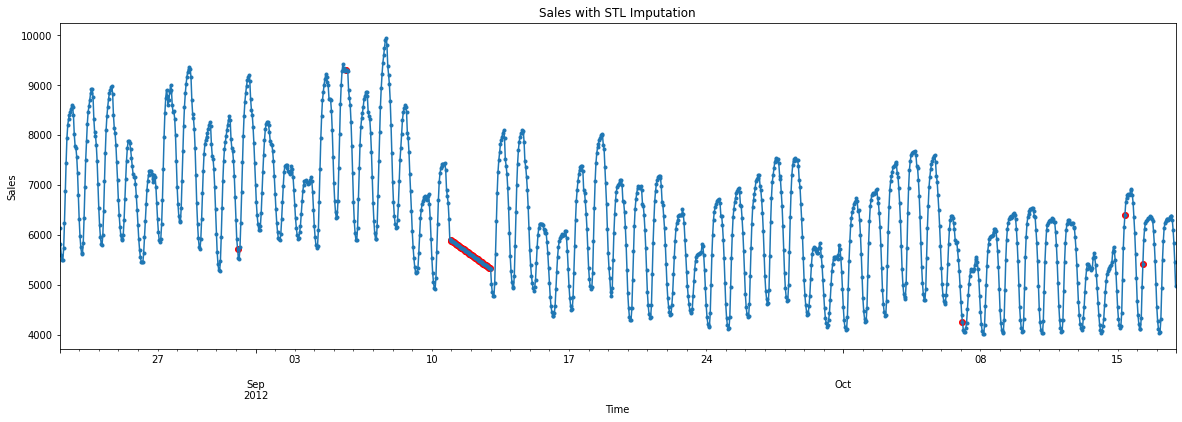

In [14]:
df = result_ls[1] # 以第一段 ('2006-05-24 00:00:00', '2012-07-23 23:00:00') 來做補值，確認哪個方法補值好

df_impute_linear, imputed_indices  = impute_linear(df)
print(f"Linear 補值後 NA number: {df_impute_linear['Load'].isna().sum()}")

plot_impute_result(df_impute_linear, imputed_indices)

#### STL

STL 補值後 NA number: 0


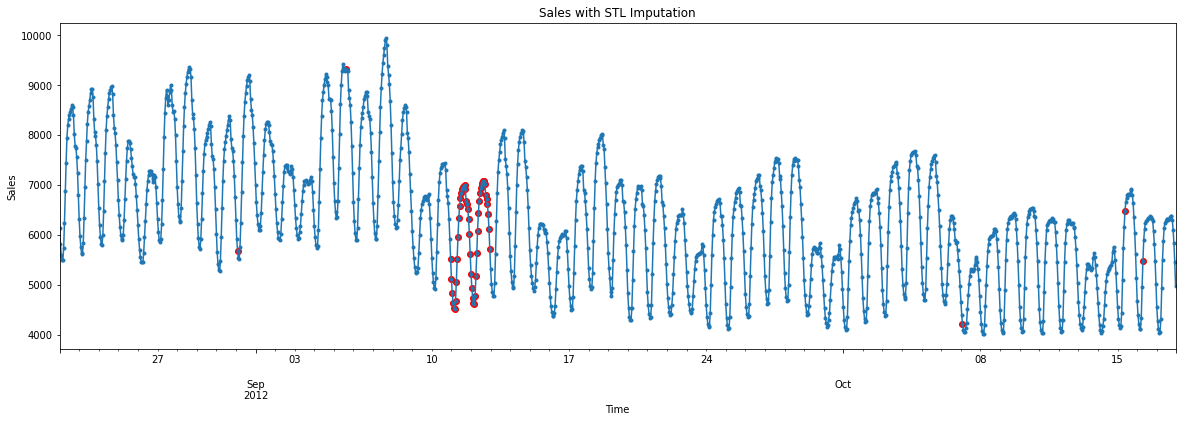

In [15]:
df = result_ls[1] # 以第一段 ('2006-05-24 00:00:00', '2012-07-23 23:00:00') 來做補值，確認哪個方法補值好

df_impute_stl, imputed_indices = impute_stl(df)
print(f"STL 補值後 NA number: {df_impute_stl['Load'].isna().sum()}")

plot_impute_result(df_impute_stl, imputed_indices)

### Impute: All zones 每個區域用STL各自補

In [16]:
df = df_all_time

'''
確認：呈現每個區域總NA值和分年NA值，確認 select_period 是否只看一個 zone 就決定
'''
total_na, month_na = count_zone_na(df)
print(total_na)
# for i in range(len(month_na)):
#     print(month_na[i])

[12493, 12493, 12494, 12493, 12494, 12495, 12493, 12509, 12494, 12493, 12514]


In [17]:
df = df_all_time

'''
做補值：每個區域和每個 period 各自補
Time: About 11.5 mins
'''
zones = df['Zone'].unique()
all_impute_stl = []
for zone in zones: # 11
    print(zone)
    # one zone in one loop
    result = df.loc[df['Zone'] == zone,]

    # 擷取 8 段期間遺失值較少的資料
    result_ls = []
    num_na = 0
    num_zone = 0
    for one_period in select_period: # 8
        # one period
        result_ = result[(result['Date'] >= one_period[0]) & (result['Date'] <= one_period[1])]
        num_zone = num_zone + result_.shape[0]
        num_na = num_na + result_['Load'].isna().sum()
        # imputation
        impute_result,imputed_indices = impute_stl(result_)
        result_ls.append(impute_result)
        # plot_stl_impute_result(impute_result)
    print(num_na)
    print(num_zone)
        


    all_impute_stl.append(result_ls)
    
all_impute_stl = all_impute_stl

CAPITL
714
142488
CENTRL
714
142488
DUNWOD
715
142488
GENESE
714
142488
HUD VL
715
142488
LONGIL
716
142488
MHK VL
714
142488
MILLWD
730
142488
N.Y.C.
715
142488
NORTH
714
142488
WEST
735
142488


In [18]:
df = all_impute_stl

'''
將 all_impute_stl (a list with 11 elements and each element has 8 elements) 
轉成一個長度為 8 的 list，每個元素是一個 concat 後的 dataframe
'''
all_impute_stl_v2 = [] # len = 8
for i in range(len(df[0])):
    temp = []
    for list_of_dfs in df: # len = 11
        df_one = list_of_dfs[i]
        df_one['Date'] = df_one.index
        df_one = df_one.reset_index(drop=True)
        temp.append(df_one) 
            
    all_impute_stl_v2.append(pd.concat(temp, axis=0))


all_impute_stl_v2 = all_impute_stl_v2    

In [19]:
# 上面轉換花費太多時間，儲存成 pkl

file_name = "all_impute_stl_v2.pkl"

open_file = open(file_name, "wb")
pickle.dump(all_impute_stl_v2, open_file)
open_file.close()

# Export data: 產出要使用的資料 (pd to np array)

## Dataset 1-1: 7/8 z normalization  (2018.12.31 以前 as TN)

要產生可以餵進 SSSD code 的資料格式 np array (observation, channel, length)

此處以七天作為一個時間序列，'2006-02-06'到'2023-09-17'(完整日資料到'2023-09-23'所以最後七天的第一天是17)共有 6433 個 observation，11個 zone作為 channel，7x24 = 168為 length

In [2]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/all_impute_stl_v2.pkl", "rb")
all_impute_stl_v2 = pickle.load(open_file)
open_file.close()

### All zones

In [5]:
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(all_impute_stl_v2, 
                                                      train_end = '2018-12-31 23:00:00', 
                                                      test_start = '2019-01-01 00:00:00',
                                                      test_end = '2019-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(str(days_window) + '_days/load_array_all_train.npy', load_array_train)
np.save(str(days_window) + '_days/load_array_all_test.npy', load_array_test)

(3688, 192, 11)
(358, 192, 11)


In [32]:
# Normalization

load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(str(days_window) + '_days/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(str(days_window) + '_days/load_array_all_test_stdd.npy', load_array_test_stdd)

### Each zone

In [34]:
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_v2[0]['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(all_impute_stl_v2, 
                                                      train_start = '2006-05-24 00:00:00'
                                                      train_end = '2018-12-31 23:00:00', 
                                                      test_start = '2019-01-01 00:00:00',
                                                      test_end = '2019-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(str(days_window) + '_days/zone/load_array_'+zones[index]+'_train.npy', load_array_train)
    np.save(str(days_window) + '_days/zone/load_array_'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(str(days_window) + '_days/zone/load_array_'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(str(days_window) + '_days/zone/load_array_'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

## Dataset 1-2: slit dataset based on dataset 1-1


split training set into training (I1) and calibration set (I2) for conformal prediction

In [ ]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/all_impute_stl_v2.pkl", "rb")
all_impute_stl_v2 = pickle.load(open_file)
open_file.close()

In [7]:
from sklearn.model_selection import train_test_split

data = np.load('/home/hchuang/Documents/UQ-DL/SSSD/src/datasets/NYISO/dataset_1/zone/load_array_N.Y.C._train_stdd.npy')
data_I1, data_I2 = train_test_split(data, test_size=0.5, random_state=42)


In [30]:
# Check if all values in data_I1 and data_I2 exist in the original data
if np.all(np.isin(data_I1, data_I2)):
    print("All values in data_I1 and data_I2 exist in the original data.")
else:
    print("Some values in data_I1 or data_I2 do not exist in the original data.")


Some values in data_I1 or data_I2 do not exist in the original data.


In [41]:
file_prefix = '/home/hchuang/Documents/UQ-DL/SSSD/src/datasets/NYISO/dataset_1/zone/load_array_N.Y.C._train_stdd_'

np.save(file_prefix + 'I1.npy', data_I1)
np.save(file_prefix + 'I2.npy', data_I2)

## Dataset 2-1: 7/8 z normalization (2014.12.31 以前 as pre-training data)

要跟文獻比較，因此依照 [excel](https://docs.google.com/spreadsheets/d/1FQVBCZh9B3l3ZHXKCaV2BaoaAKnp1zMHvkxCsjfNxO4/edit#gid=0) 列出的時間，分割資料集。共有五個資料集

In [3]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/all_impute_stl_v2.pkl", "rb")
all_impute_stl_v2 = pickle.load(open_file)
open_file.close()

### Each zone and mix zone

In [6]:
def save_zone_datasets(dataname, data, data_ls, path):
    """
    data_ls is a list collect every zone
    dataname is one of [pre_train_data, fine_tune_data_1, fine_tune_data_2, test_data_0, test_data_1, test_data_2]
    """
    data_stdd = z_normalization(data, days_normalized = 7)
    np.save(path + 'zone/' + zones[index] + '_' + dataname + '.npy', data)
    np.save(path + 'zone/' + zones[index] + '_' + dataname + '_stdd.npy', data_stdd)
    data_ls.append(data)



def save_mix_datasets(dataname, data_ls, path):
    """
    data_ls is a list collect every zone
    dataname is one of [pre_train_data, fine_tune_data_1, fine_tune_data_2, test_data_0, test_data_1, test_data_2]
    """
    data_mix   = np.concatenate(data_ls, axis=0)        
    data_mix_stdd = z_normalization(data_mix, days_normalized = 7)
    np.save(path + 'mix/mix_' + dataname + '.npy', data_mix)
    np.save(path + 'mix/mix_' + dataname + '_stdd.npy', data_mix_stdd)



In [7]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_v2[0]['Zone'].unique()


pre_train_data_ls = []; fine_tune_data_1_ls = []; fine_tune_data_2_ls = []
test_data_0_ls = []; test_data_1_ls = []; test_data_2_ls = []

six_dataname = ['pre_train_data', 'fine_tune_data_1', 'fine_tune_data_2',
                 'test_data_0', 'test_data_1', 'test_data_2']
six_data_list = [pre_train_data_ls, fine_tune_data_1_ls, fine_tune_data_2_ls, 
                 test_data_0_ls, test_data_1_ls, test_data_2_ls]
for index in range(len(zones)):
    pre_train_data, test_data_0 = train_test_select(all_impute_stl_v2, 
                                                      train_start = '2006-05-24 00:00:00',
                                                      train_end = '2015-01-12 23:00:00', 
                                                      test_start = '2015-01-06 00:00:00', # '2015-01-13 00:00:00'
                                                      test_end = '2015-01-14 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])
    fine_tune_data_1, test_data_1 = train_test_select(all_impute_stl_v2, 
                                                      train_start = '2015-01-13 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00', # '2016-10-20 00:00:00'
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])                                                          
    fine_tune_data_2, test_data_2= train_test_select(all_impute_stl_v2, 
                                                      train_start = '2015-01-13 00:00:00',
                                                      train_end = '2016-12-31 23:00:00', 
                                                      test_start = '2016-12-25 00:00:00', # '2017-01-01 00:00:00'
                                                      test_end = '2017-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])  
    six_data = [pre_train_data, fine_tune_data_1, fine_tune_data_2, test_data_0, test_data_1, test_data_2]
    for i in range(len(six_dataname)):
        save_zone_datasets(six_dataname[i], six_data[i], six_data_list[i], path)

    

In [8]:
for i in range(len(six_data_list)):
    save_mix_datasets(six_dataname[i], six_data_list[i], path)

In [4]:
print(six_data[0].shape)
print(six_data[1].shape)
print(six_data[2].shape)
print(six_data[3].shape)
print(six_data[4].shape)
print(six_data[5].shape)

(2969, 192, 1)
(639, 192, 1)
(712, 192, 1)
(2, 192, 1)
(73, 192, 1)
(365, 192, 1)


In [18]:
mix_pre_train_data_stdd = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_pre_train_data_stdd.npy')
print(mix_pre_train_data_stdd.shape)
mix_fine_tune_data_1_stdd = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_fine_tune_data_1_stdd.npy')
print(mix_fine_tune_data_1_stdd.shape)
mix_fine_tune_data_2_stdd = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_fine_tune_data_2_stdd.npy')
print(mix_fine_tune_data_2_stdd.shape)
mix_test_data_0 = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_test_data_0_stdd.npy')
print(mix_test_data_0.shape)
mix_test_data_1 = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_test_data_1_stdd.npy')
print(mix_test_data_1.shape)
mix_test_data_2 = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/mix/mix_test_data_2_stdd.npy')
print(mix_test_data_2.shape)



(32659, 192, 1)
(7029, 192, 1)
(7832, 192, 1)
(22, 192, 1)
(803, 192, 1)
(4015, 192, 1)


### All zone

In [7]:
def save_all_datasets(dataname, data, path):
    """
    dataname is one of [pre_train_data, fine_tune_data_1, fine_tune_data_2, test_data_0, test_data_1, test_data_2]
    """
    data_stdd = z_normalization(data, days_normalized = 7)
    np.save(path + 'all/all_' + dataname + '.npy', data)
    np.save(path + 'all/all_' + dataname + '_stdd.npy', data_stdd)


In [8]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_2/'
days_window = 8 # 幾天一組（也就是預測第幾天）
# zones = all_impute_stl_v2[0]['Zone'].unique()


pre_train_data_ls = []; fine_tune_data_1_ls = []; fine_tune_data_2_ls = []
test_data_0_ls = []; test_data_1_ls = []; test_data_2_ls = []

six_dataname = ['pre_train_data', 'fine_tune_data_1', 'fine_tune_data_2',
                 'test_data_0', 'test_data_1', 'test_data_2']
six_data_list = [pre_train_data_ls, fine_tune_data_1_ls, fine_tune_data_2_ls, 
                 test_data_0_ls, test_data_1_ls, test_data_2_ls]

pre_train_data, test_data_0 = train_test_select(all_impute_stl_v2, 
                                                    train_start = '2006-05-24 00:00:00',
                                                    train_end = '2015-01-12 23:00:00', 
                                                    test_start = '2015-01-06 00:00:00', # '2015-01-13 00:00:00'
                                                    test_end = '2015-01-14 23:00:00',
                                                    zone_number = 11,
                                                    days_window = days_window,
                                                    zone_name = 'ALL')
fine_tune_data_1, test_data_1 = train_test_select(all_impute_stl_v2, 
                                                    train_start = '2015-01-13 00:00:00',
                                                    train_end = '2016-10-19 23:00:00', 
                                                    test_start = '2016-10-13 00:00:00', # '2016-10-20 00:00:00'
                                                    test_end = '2016-12-31 23:00:00',
                                                    zone_number = 11,
                                                    days_window = days_window,
                                                    zone_name = 'ALL')                                                          
fine_tune_data_2, test_data_2= train_test_select(all_impute_stl_v2, 
                                                    train_start = '2015-01-13 00:00:00',
                                                    train_end = '2016-12-31 23:00:00', 
                                                    test_start = '2016-12-25 00:00:00', # '2017-01-01 00:00:00'
                                                    test_end = '2017-12-31 23:00:00',
                                                    zone_number = 11,
                                                    days_window = days_window,
                                                    zone_name = 'ALL')  
six_data = [pre_train_data, fine_tune_data_1, fine_tune_data_2, test_data_0, test_data_1, test_data_2]
for i in range(len(six_dataname)):
    save_all_datasets(six_dataname[i], six_data[i], path)

    

In [6]:
test_data_2.shape

(365, 192, 11)